In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

In [6]:

def find_project_root(markers=("pyproject.toml", ".git")) -> Path:
    """
    Descobre a raiz do projeto subindo diretórios até encontrar um marcador.

    Parâmetros:
        markers: nomes de arquivos/pastas que indicam a raiz (ex.: "pyproject.toml", ".git").

    Retorna:
        pathlib.Path apontando para a raiz do projeto, ou o diretório atual como fallback.
    """
    p = Path.cwd().resolve()
    for parent in [p, *p.parents]:
        if any((parent / m).exists() for m in markers):
            return parent
    return p

ROOT = find_project_root()

In [11]:
# --- Configurações ---
# Configurações
DATA_DIR = ROOT / "data"
DATASET_DIR = DATA_DIR / "raw" / "dataset"

IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 149 # Número de símbolos
MODEL_SAVE_PATH = DATA_DIR / "processed" / "modelo_ocr_simbolos.keras"

In [8]:
# --- Carregamento e Preparação dos Dados ---
def load_datasets():
    """Carrega os datasets de treino, validação e teste."""

    class_names = sorted(os.listdir(os.path.join(DATASET_DIR, 'train')))


    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATASET_DIR, 'train'),
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        color_mode='grayscale',
        # lambel_mode='categorical',
        label_mode='int',
        validation_split=None,
        # seed=123,
        class_names=class_names  # garante mapeamento idêntico
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATASET_DIR, 'validation'),
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        color_mode='grayscale',
        # label_mode='categorical',
        label_mode='int',
        validation_split=None,
        # seed=123,
        class_names=class_names  # garante mapeamento idêntico
    )
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATASET_DIR, 'test'),
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        color_mode='grayscale',
        # label_mode='categorical',
        label_mode='int',
        class_names=class_names
    )

    # class_names = train_ds.class_names
    # print(f'Classes encontradas: {class_names}')

    return train_ds, val_ds, test_ds, class_names

In [9]:
def build_model():
    """Constrói a arquitetura da Rede Neural Convolucional."""
    model = models.Sequential([
        # Camada de normalização para reescalar os pixels para [0,1]
        layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

        # Camada Convolucional 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Camada Convolucional 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Camada Convolucional 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Camada de Classificação
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax') # Camada de saída
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [10]:
def plot_history(history):
    """Plota os gráficos de acurácia e perda do treinamento."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Acurácia de Treino')
    plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
    plt.legend(loc='lower right')
    plt.title('Acurácia de Treino e Validação')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perda de Treino')
    plt.plot(epochs_range, val_loss, label='Perda de Validação')
    plt.legend(loc='upper right')
    plt.title('Perda de Treino e Validação')
    plt.show()

Found 102263 files belonging to 146 classes.


I0000 00:00:1760800280.586001    9059 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 21770 files belonging to 146 classes.
Found 21967 files belonging to 146 classes.


/home/max/.pyenv/versions/mambaforge-23.11.0-0/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 149)            │        38,293 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,228,373 (8.50 MB)

 Trainable params: 2,228,373 (8.50 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento...
Epoch 1/20


2025-10-18 12:11:46.602637: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ed8e8019940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-18 12:11:46.602672: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-10-18 12:11:46.632925: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-18 12:11:46.813938: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-10-18 12:11:46.897434: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-18 12:11:46.

   9/3196 ━━━━━━━━━━━━━━━━━━━━ 54s 17ms/step - accuracy: 0.0089 - loss: 5.0447    

I0000 00:00:1760800311.569944   10218 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3195/3196 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5127 - loss: 1.9305

2025-10-18 12:13:57.925056: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-18 12:13:57.925102: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-18 12:13:58.496369: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_336', 8 bytes spill stores, 8 bytes spill loads

2025-10-18 12:13:58.507410: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

3196/3196 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5128 - loss: 1.9302

2025-10-18 12:14:01.305030: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-18 12:14:01.792181: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_100', 12 bytes spill stores, 12 bytes spill loads



3196/3196 ━━━━━━━━━━━━━━━━━━━━ 158s 48ms/step - accuracy: 0.7314 - loss: 0.9114 - val_accuracy: 0.9365 - val_loss: 0.1346
Epoch 2/20
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9123 - loss: 0.2064 - val_accuracy: 0.9430 - val_loss: 0.1055
Epoch 3/20
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9272 - loss: 0.1594 - val_accuracy: 0.9458 - val_loss: 0.0935
Epoch 4/20
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9345 - loss: 0.1363 - val_accuracy: 0.9464 - val_loss: 0.0941
Epoch 5/20
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9379 - loss: 0.1235 - val_accuracy: 0.9468 - val_loss: 0.0899
Epoch 6/20
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9420 - loss: 0.1132 - val_accuracy: 0.9473 - val_loss: 0.0887
Epoch 7/20
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9444 - loss: 0.1080 - val_accuracy: 0.9472 - val_loss: 0.0886
Epoch 8/20
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9453 - loss: 0.1045 - v

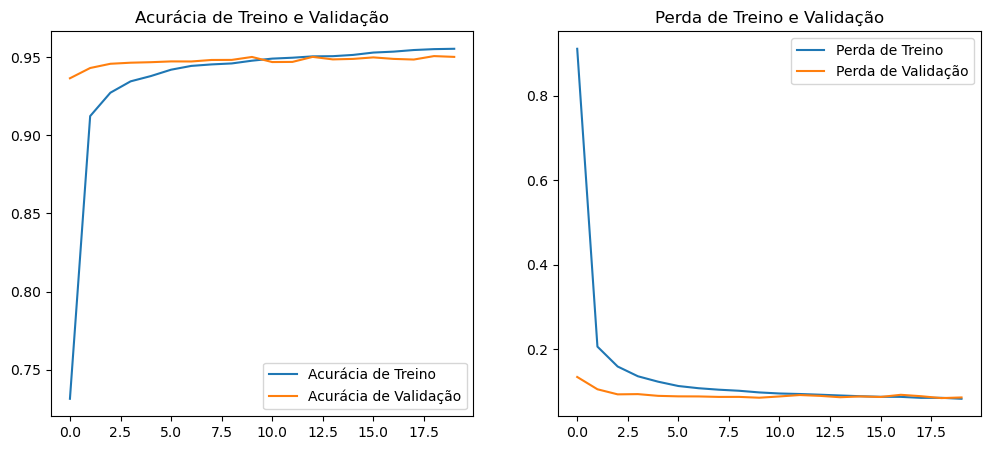

In [12]:
if not os.path.exists(DATASET_DIR):
    print(f"ERRO: Diretório '{DATASET_DIR}' não encontrado. Execute o script 'gerador_dataset.py' primeiro.")
else:
    train_ds, val_ds, test_ds, class_names = load_datasets()

    # Otimiza a performance de carregamento dos dados
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    with tf.device('/GPU:0'):
        model = build_model()
    model.summary()

    print("\nIniciando o treinamento...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS
    )

    print("\nTreinamento concluído!")

    # Salva o modelo treinado
    model.save(MODEL_SAVE_PATH)
    print(f"Modelo salvo em '{MODEL_SAVE_PATH}'")

    # Avalia o modelo no conjunto de teste
    print("\nAvaliando o modelo no conjunto de teste...")
    test_loss, test_acc = model.evaluate(test_ds, verbose=2)
    print(f"\nAcurácia no conjunto de teste: {test_acc:.4f}")

    # Plota os gráficos
    plot_history(history)


In [13]:
# Exportar class_names
import json

CLASS_NAMES_PATH = DATA_DIR / "raw" / "class_names.json"

with open(CLASS_NAMES_PATH, 'w', encoding='utf-8') as f:
    json.dump(class_names, f, ensure_ascii=False)
print("Nomes das classes salvos em 'class_names.json'")
print("Processo concluído!")

Nomes das classes salvos em 'class_names.json'
Processo concluído!


In [14]:
for idx, name in enumerate(class_names):
    print(idx, name)

0 U+0020
1 U+0021
2 U+0022
3 U+0023
4 U+0024
5 U+0025
6 U+0026
7 U+0027
8 U+0028
9 U+0029
10 U+002A
11 U+002B
12 U+002C
13 U+002D
14 U+002E
15 U+002F
16 U+0030
17 U+0031
18 U+0032
19 U+0033
20 U+0034
21 U+0035
22 U+0036
23 U+0037
24 U+0038
25 U+0039
26 U+003A
27 U+003B
28 U+003C
29 U+003E
30 U+003F
31 U+0040
32 U+0041
33 U+0042
34 U+0043
35 U+0044
36 U+0045
37 U+0046
38 U+0047
39 U+0048
40 U+0049
41 U+004A
42 U+004B
43 U+004C
44 U+004D
45 U+004E
46 U+004F
47 U+0050
48 U+0051
49 U+0052
50 U+0053
51 U+0054
52 U+0055
53 U+0056
54 U+0057
55 U+0058
56 U+0059
57 U+005A
58 U+005C
59 U+005F
60 U+0061
61 U+0062
62 U+0063
63 U+0064
64 U+0065
65 U+0066
66 U+0067
67 U+0068
68 U+0069
69 U+006A
70 U+006B
71 U+006C
72 U+006D
73 U+006E
74 U+006F
75 U+0070
76 U+0071
77 U+0072
78 U+0073
79 U+0074
80 U+0075
81 U+0076
82 U+0077
83 U+0078
84 U+0079
85 U+007A
86 U+00A2
87 U+00A3
88 U+00A7
89 U+00A8
90 U+00AC
91 U+00B0
92 U+00B2
93 U+00B3
94 U+00B7
95 U+00B9
96 U+00BA
97 U+00C0
98 U+00C1
99 U+00C2
100 U+00C3